# 題目
- 台股或美股，1. 預測收盤價(回歸)，2. 預測漲跌(分類)

## 注意事項
- 深度學習建議使用 Nvidia GPU , 激活 Pytorch CUDA 加速功能 , 在 Colab 推薦使用 Nvidia T4 之上的 GPU 加速訓練與推理速度

## Colab 環境介紹
- 整體為 VM (虛擬機)
- OS : Ubuntu 22.04 LTS
- CPU : 虛擬化 CPU 雙核約 2GHz
- RAM : 約 12.7 GB , 頻率不一定
- Disk : 約 112.6 GB , 讀寫速度不一定

## NVIDIA T4 GPU (GPU直通)
- NVIDIA CUDA 核心 : 2,560
- VRAM : 16 GB GDDR6 , 可用約 15.0 GB , 頻寬320+ GB/s
- FP32 : 8.1 TFLOPS
- FP16/FP32 : 65 FP16 TFLOPS
- INT8 : 130 INT8 TOPS
- INT4 : 260 INT4 TOPS
- PCle : Gen3 x16

## 本地運算
- RTX 4090 24G

## 使用過去的程式碼 
- [112-2 程式設計(Python)](https://github.com/TsukiSama9292/112-2_Python)
- [113-1 大數據分析與智慧運算(期中報告)](https://github.com/TsukiSama9292/113-1_BigData)


# 基本套件安裝

In [1]:
# 台股資訊套件
!pip install -U -qqq twstock
!pip install -U -qqq lxml
# 數據處理套件
!pip install -U -qqq pandas numpy scikit-learn matplotlib

# 獲取台灣股票資訊

In [1]:
import csv
from twstock import Stock
import os
# 求某年至 end_year end_month 月之前的資訊
def get_stock_info_between_years_to_csv(stock_id, start_year=2000, end_year=2024, end_month=11):
    # 使用 twstock 模組的 Stock 類來獲取股票資訊
    stock = Stock(stock_id)

    # 初始化一個空列表來存儲資訊
    all_info = []
    # 取從開始年到現今的紀錄
    info = stock.fetch_from(start_year, 1)
    all_info.extend(info)
    # 找到 end_year 年 end_month 月之後的第一個索引
    for i, data in enumerate(all_info):
        if data.date.year == end_year and data.date.month >= end_month:
            break
    else:
        i = len(all_info)  # 如果找不到 end_year 年 end_month 月之後的資訊，保留全部

    # 刪除 end_year 年 end_month 月之後的紀錄
    all_info = all_info[:i]
    # 獲取當前工作目錄
    current_directory = os.getcwd()  
    # 將資訊寫入 CSV 檔案
    global filename
    filename = os.path.join(current_directory, f"{stock_id}_{start_year}_to_{end_year}{end_month}.csv")
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)

        # 寫入 CSV 標題行
        csvwriter.writerow(['Open', 'High', 'Low', 'Close', 'Change', 'Volume' , 'Date'])

        # 寫入資訊行
        for data in all_info:
            csvwriter.writerow([data.open, data.high, data.low, data.close, data.change, data.capacity, data.date.strftime('%Y-%m-%d')])

    print(f"已將 {stock_id} 在 {start_year} 年至 {end_year} 年 {end_month} 月的資訊儲存為 {filename}")

# 使用範例，台機電股票
get_stock_info_between_years_to_csv(stock_id='2330', start_year=2000, end_year=2024, end_month=11)

已將 2330 在 2000 年至 2024 年 11 月的資訊儲存為 /2330_2000_to_202411.csv


# 股票預測 - Pytorch 深度學習 - B1143015 林宣佑

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import datetime
import time
import pickle

In [3]:
# Get the current time
current_time = datetime.datetime.now()

# Format the time
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")

print("Current time:", formatted_time)

# Read the data
data = pd.read_csv(filename)

# Select the necessary features and target variable
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
target = data['Change']

# Modify the target values
def transform_target(value):
    if value < 0:
        return [1, 0, 0]  # Negative change
    elif value == 0:
        return [0, 1, 0]  # No change
    else:
        return [0, 0, 1]  # Positive change

# Modify the target data into categorical data (originally [0,0,0])
new_target = []
for value in target:
    new_target.append(transform_target(value))

# Normalize the data using a dictionary of scalers
scalers = {}
scaled_features = []

for feature in features.columns:
    scaler = MinMaxScaler()
    scaled_feature = scaler.fit_transform(features[[feature]])
    scalers[feature] = scaler  # Save the scaler for each feature
    scaled_features.append(scaled_feature)

# Convert the list of scaled features back to a DataFrame
scaled_features = np.hstack(scaled_features)
print("scaled_features : ", scaled_features[0])

# 保存 scaler 字典到檔案
with open('scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

print("Scaler 字典成功保存。")

# Split the data into training and testing sets, 80% training, 20% testing
train_size = int(len(scaled_features) * 0.8)
test_size = len(scaled_features) - train_size

train_features = scaled_features[:train_size]
train_target = new_target[:train_size]
test_features = scaled_features[train_size:]
test_target = new_target[train_size:]
print("train_features : ",train_features[0])

# Create input format for ANNs
def create_sequences(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step), :])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

# Time step for ANNs
time_step = 10

# Create training and testing data
X_train, y_train = create_sequences(train_features, train_target, time_step)
X_test, y_test = create_sequences(test_features, test_target, time_step)

# 檢測設備是否支援 CUDA 加速，沒有 CUDA 則使用 CPU
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print("*****CUDA Status*****")
print(f"CUDA Available: {USE_CUDA}")
if USE_CUDA:
    print(f"CUDA Device: {torch.cuda.current_device()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(device)}")

# Convert training feature data to PyTorch tensor, specifying the data type as float32, then move it to the specified device (GPU or CPU)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)

# Convert training target data to PyTorch tensor, specifying the data type as float32, and reshape, then move it to the specified device (GPU or CPU)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

# Convert testing feature data to PyTorch tensor, specifying the data type as float32, then move it to the specified device (GPU or CPU)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Convert testing target data to PyTorch tensor, specifying the data type as float32, and reshape, then move it to the specified device (GPU or CPU)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print("****Data Status****")
print(f"Training data: {len(X_train_tensor)} records")
print(f"Testing data: {len(X_test_tensor)} records")

Current time: 2024_12_05_23_55_11
scaled_features :  [0.00713322 0.00681317 0.00684262 0.00749173 0.21746397]
Scaler 字典成功保存。
train_features :  [0.00713322 0.00681317 0.00684262 0.00749173 0.21746397]
*****CUDA Status*****
CUDA Available: True
CUDA Device: 0
CUDA Device Name: NVIDIA GeForce RTX 4090
****Data Status****
Training data: 2900 records
Testing data: 718 records



*****Model Status*****
Stock_ANNs(
  (relu): Linear(in_features=5, out_features=200, bias=True)
  (lstm): LSTM(200, 200, num_layers=2, batch_first=True, dropout=0.001)
  (output): Linear(in_features=200, out_features=3, bias=True)
)

*****Training Status*****
| epoch  10 | lr 0.0005000000 | 74.39 ms | loss 43.3090717 | train accuracy 48.45%
| epoch  20 | lr 0.0004875000 | 74.60 ms | loss 43.2558471 | train accuracy 48.38%
| epoch  30 | lr 0.0004753125 | 83.54 ms | loss 43.1885068 | train accuracy 49.14%
| epoch  40 | lr 0.0004634297 | 82.62 ms | loss 43.1223992 | train accuracy 48.90%
| epoch  50 | lr 0.0004518439 | 77.69 ms | loss 43.0311986 | train accuracy 48.52%
| epoch  60 | lr 0.0004405478 | 100.98 ms | loss 42.7886369 | train accuracy 48.66%
| epoch  70 | lr 0.0004295342 | 72.21 ms | loss 42.2248117 | train accuracy 49.90%
| epoch  80 | lr 0.0004187958 | 62.46 ms | loss 41.5154729 | train accuracy 51.48%
| epoch  90 | lr 0.0004083259 | 90.67 ms | loss 40.5585563 | train accurac

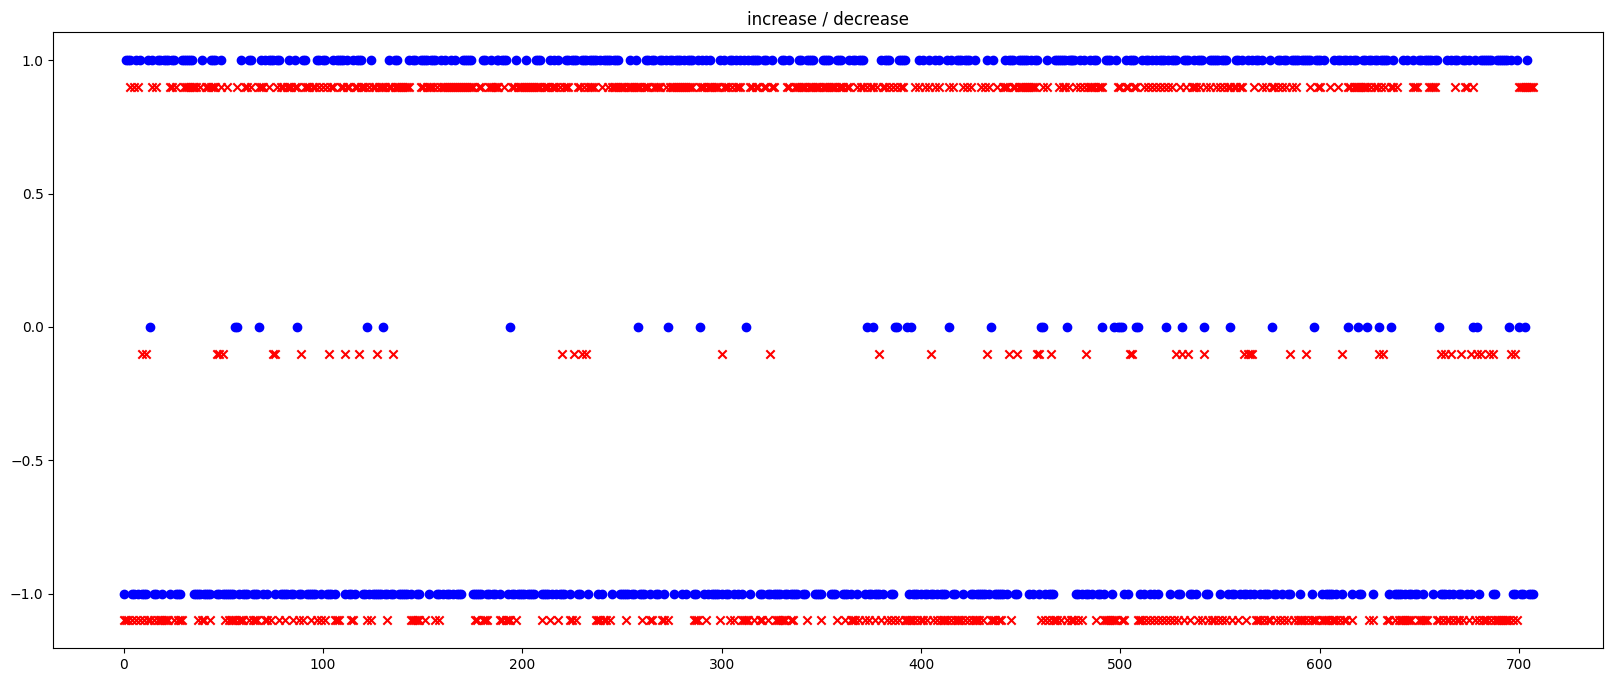


*****Model Status*****
Stock_ANNs(
  (relu): Linear(in_features=5, out_features=200, bias=True)
  (lstm): LSTM(200, 200, num_layers=2, batch_first=True, dropout=0.001)
  (output): Linear(in_features=200, out_features=3, bias=True)
)

*****Training Status*****
| epoch  10 | lr 0.0005000000 | 74.31 ms | loss 43.3541959 | train accuracy 48.38%
| epoch  20 | lr 0.0004875000 | 63.01 ms | loss 43.2127074 | train accuracy 48.83%
| epoch  30 | lr 0.0004753125 | 72.76 ms | loss 43.1799918 | train accuracy 48.52%
| epoch  40 | lr 0.0004634297 | 90.75 ms | loss 43.1955373 | train accuracy 48.41%
| epoch  50 | lr 0.0004518439 | 74.77 ms | loss 43.0819255 | train accuracy 48.55%
| epoch  60 | lr 0.0004405478 | 68.32 ms | loss 42.9632734 | train accuracy 49.00%
| epoch  70 | lr 0.0004295342 | 67.41 ms | loss 42.6053226 | train accuracy 49.45%
| epoch  80 | lr 0.0004187958 | 74.69 ms | loss 42.2858465 | train accuracy 49.79%
| epoch  90 | lr 0.0004083259 | 67.75 ms | loss 41.9705237 | train accuracy

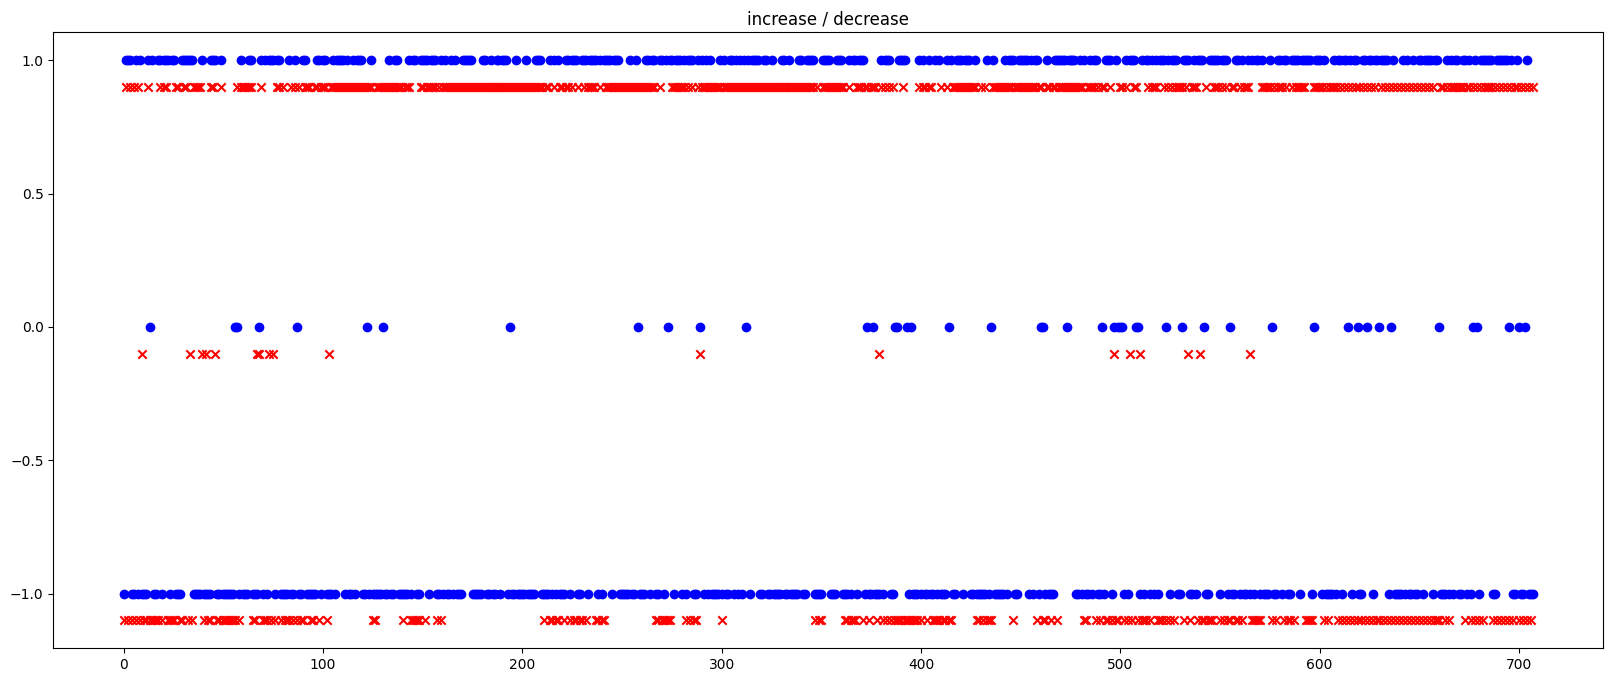

預測達到 48.5% 正確率，停止訓練


In [19]:
class Stock_ANNs(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(Stock_ANNs, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.relu = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.output = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.relu(x)) # ReLU
        # Initialize the hidden and cell states of the LSTM to zeros and move them to the specified device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # Move the input data to the specified device and pass it to the LSTM layer, getting the output and new hidden and cell states
        out, (hn, cn) = self.lstm(x.to(device), (h0.detach(), c0.detach()))
        # Pass the LSTM output to the fully connected layer, using only the output of the last time step
        out = self.output(out[:, -1, :])
        # Move the final output to the specified device and return
        return out.to(device)

# Convert predicted values to labels
def map_to_label(array):
    labels = []
    for row in array:
        max_index = np.argmax(row)
        if max_index == 0:
            labels.append(-1)
        elif max_index == 1:
            labels.append(0)
        elif max_index == 2:
            labels.append(1)
    return labels


# 設定模型各層維度
input_dim = X_train.shape[2] # 輸入
hidden_dim = 200  # 隱藏 , 像神經一樣的概念
num_layers = 2 # LSTM 
output_dim = 3   # 輸出
dropout = 0.001 # 防止過擬合

# 訓練參數設置
epochs = 150     # 訓練次數

# Initialize the learning rate
initial_lr = 5e-4
# Set the batch size
batch_size = 64
# # Calculate the scaling factor based on the ratio of the new batch size to the original batch size
# scale_factor = batch_size / 64 # Original batch size is 64
# # Adjust the learning rate to grow proportionally with the new batch size
# lr = initial_lr * scale_factor
lr = initial_lr
criterion = nn.CrossEntropyLoss()  # 損失函數

while True:
    # 模型建立並移動到 device (CPU 或 GPU)
    model = Stock_ANNs(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 優化器
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.975)  # 調節學習率工具
    print("\n*****Model Status*****")
    print(model)  # 顯示模型結構

    # 訓練模型
    print("\n*****Training Status*****")
    train_start = time.time()
    for epoch in range(1, epochs + 1):
        model.train()  # 將模型設置為訓練模式
        total_loss = 0  # 紀錄 LOSS
        total_correct = 0  # 紀錄正確預測數量
        total_samples = 0  # 紀錄樣本數量
        start_time = time.time()  # 記錄當前epoch的開始時間
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i + batch_size]  # 從訓練集中取出一個批次的特徵數據
            batch_y = y_train_tensor[i:i + batch_size]  # 從訓練集中取出一個批次的目標數據
            outputs = model(batch_X)  # 獲取模型的預測結果
            loss = criterion(outputs, batch_y)  # 計算模型的損失
            optimizer.zero_grad()  # 梯度反向傳播和參數更新
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # 計算批次的準確率
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == batch_y.argmax(dim=1)).sum().item()
            total_samples += batch_y.size(0)

        # 計算整個epoch的準確率
        train_accuracy = total_correct / total_samples

        # 每十次輸出訓練狀態
        # 第幾步驟 , 學習率, 訓練時間 , LOSS , 訓練資料準確率
        if epoch % 10 == 0:
            print('| epoch {:3d} | lr {:02.10f} | {:5.2f} ms | loss {:5.7f} | train accuracy {:3.2f}%'.format(
                epoch, scheduler.get_last_lr()[0], (time.time() - start_time) * 1000, total_loss, train_accuracy * 100))
        scheduler.step()  # 每個epoch結束後調整學習率(記數)

    train_times = time.time() - train_start  # 計算整個訓練過程的總執行時間
    print(f"Training cost: {train_times:.2f} seconds")  # 打印整個訓練過程的執行時間


    # 混淆矩陣和評估指標
    print("\n*****Eval Status*****")
    model.eval()
    test_outputs = model(X_test_tensor)

    predicted = test_outputs[10:].detach().cpu().numpy()
    actual = y_test_tensor[10:].cpu().numpy()

    # Convert predicted values and actual values to class labels
    predicted_labels = map_to_label(predicted)
    actual_labels = map_to_label(actual)

    # 打印混淆矩陣
    conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=[-1,0,1])
    print("Confusion Matrix:")
    print(conf_matrix)

    # 打印 正確率 , 精確率 , 召回率
    print(f"Accuracy: {accuracy_score(actual_labels, predicted_labels) * 100:.2f}%")
    print(f"Precision: {precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0) * 100:.2f}%")
    print(f"Recall: {recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0) * 100:.2f}%")
    print(f"F1 Score: {f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0) * 100:.2f}%")

    # Offset predicted values
    offset_predicted = [value - 0.1 for value in predicted_labels]  # Offset predicted values downward by subtracting 0.1
    # Create a chart
    plt.figure(figsize=(20, 8))
    # Plot the scatter plot of actual values
    plt.scatter(range(len(actual_labels)), actual_labels, color='blue', label='Actual Price Change (%)', marker='o')
    # Plot the scatter plot of offset predicted values
    plt.scatter(range(len(offset_predicted)), offset_predicted, color='red', label='Predicted Price Change (%)', marker='x')
    # Set the chart title and legend
    plt.title('increase / decrease')
    # Show the chart
    plt.show()
    break_acc = 48.5
    if (accuracy_score(actual_labels, predicted_labels) * 100) >= break_acc :
        print(f"預測達到 {break_acc}% 正確率，停止訓練")
        break



# 模型保存

In [24]:
from huggingface_hub import HfApi
from safetensors.torch import save_file
import os

try:
    from google.colab import userdata
    api_token = userdata.get('Colab_ALL')  # 在 Colab 中獲取 API_TOKEN
except ImportError:
    from dotenv import load_dotenv
    import os
    load_dotenv('api.env')  # 載入 .env 檔案
    api_token = os.getenv('HF_API_TOKEN')  # 在其他環境中獲取 HF_API_TOKEN

# 設定 Git 用戶名和電子郵件 , 改為自己 git 帳號
!git config --global user.email "a0985821880@gmail.com"
!git config --global user.name "TsukiSama9292"
# 設定 hugging face 帳號和模型名稱
USER_NAME = "TsukiOwO"
MODEL_NAME = "Stock_ANNs_Classifier"

model_save_path = f"{MODEL_NAME}.safetensors"
repo_name = f"{USER_NAME}/{MODEL_NAME}"
api = HfApi()

# 建構 HF 模型儲存庫
try:
    api.create_repo(repo_id=repo_name, token=api_token, private=False)
    print(f"儲存庫 '{repo_name}' 建立成功。")
except Exception as e:
    print(f"建構儲存庫操作時發生錯誤: {e}")

# 提取模型權重並保存為 safetensors 格式
model_weights = {name: tensor for name, tensor in model.state_dict().items()}  # 提取每個張量
save_file(model_weights, model_save_path)

# 檢查檔案是否成功保存
if os.path.exists(model_save_path):
    print(f"模型成功保存於 {model_save_path}。")
else:
    print(f"模型保存失敗於 {model_save_path}。")


# 上傳模型到 Hugging Face
try:
    # 使用 HfApi 上傳
    api.upload_file(
        path_or_fileobj=model_save_path,
        path_in_repo=model_save_path,
        repo_id=repo_name,
        token=api_token
    )
    print(f"模型已上傳至 Hugging Face: {repo_name}")
except Exception as e:
    print(f"儲存庫操作時發生錯誤: {e}")

建構儲存庫操作時發生錯誤: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-67524229-0d90c2e71fa220ca2866d5f9;0b6e9ff7-2f0f-4dd2-b4c6-8007545703db)

You already created this model repo
模型成功保存於 Stock_ANNs_Classifier.safetensors。


No files have been modified since last commit. Skipping to prevent empty commit.


模型已上傳至 Hugging Face: TsukiOwO/Stock_ANNs_Classifier
